In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# random seed
seed = 42
torch.manual_seed(seed)
random.seed(seed)

In [3]:
# define MLP 
class SentimentMLP(nn.Module):
    def __init__(self, input_size=10, hidden_size=32, output_size=1):
        super(SentimentMLP, self).__init__()
        # network layers with normalization
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.norm3 = nn.LayerNorm(hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)  # define Dropout with p=0.3

    def forward(self, x):
        # layer 1 forward propagation with normalization and dropout
        x1 = self.dropout(self.relu(self.norm1(self.fc1(x))))
        
        # layer 2
        x2 = self.dropout(self.relu(self.norm2(self.fc2(x1)) + x1))
        
        # layer 3
        x3 = self.dropout(self.relu(self.norm3(self.fc3(x2)) + x2))
        
        # output layer
        output = self.fc_out(x3)
        return output

In [4]:
# load data
data = pd.read_csv('/Users/hengjiyao/Desktop/spml sem1/EE6405 NLP/6GN-GameRatingPrediction/model_2/model_1_output_with_score.csv')

# preprocess data
X = data.loc[:, '0.0-0.1':'0.9-1.0'].values  
y = data['game_rating'].values       

# standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# convert data to tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

# model initialization
input_size = X_train.shape[1]  
hidden_size = 32
output_size = 1
model = SentimentMLP(input_size, hidden_size, output_size)

# loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

torch.Size([290, 10]) torch.Size([290, 1])
torch.Size([73, 10]) torch.Size([73, 1])


In [5]:
# train model
num_epochs = 150
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()  # graidient to zero
    output = model(X_train_tensor)  # forward pass
    loss = criterion(output, y_train_tensor)  # compute the loss
    loss.backward()  # backward pass
    optimizer.step()  # update the weights
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/150], Loss: 10.7352
Epoch [20/150], Loss: 4.4240
Epoch [30/150], Loss: 2.2572
Epoch [40/150], Loss: 1.5406
Epoch [50/150], Loss: 1.4986
Epoch [60/150], Loss: 1.5421
Epoch [70/150], Loss: 1.3786
Epoch [80/150], Loss: 1.3911
Epoch [90/150], Loss: 1.4031
Epoch [100/150], Loss: 1.1730
Epoch [110/150], Loss: 1.1671
Epoch [120/150], Loss: 1.2030
Epoch [130/150], Loss: 0.9886
Epoch [140/150], Loss: 1.1075
Epoch [150/150], Loss: 1.1173


In [6]:
# evaluate model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    for i in range(len(y_test)):
        print(f"Predicted: {predictions[i].item():.2f}, Actual: {y_test[i]:.2f}")

Test Loss: 0.2699
Predicted: 3.71, Actual: 3.05
Predicted: 3.73, Actual: 4.29
Predicted: 3.62, Actual: 4.51
Predicted: 3.88, Actual: 3.59
Predicted: 3.58, Actual: 4.08
Predicted: 3.43, Actual: 3.08
Predicted: 3.93, Actual: 4.35
Predicted: 3.72, Actual: 4.22
Predicted: 3.95, Actual: 3.88
Predicted: 3.64, Actual: 3.54
Predicted: 3.59, Actual: 3.10
Predicted: 3.61, Actual: 3.47
Predicted: 3.62, Actual: 3.62
Predicted: 3.71, Actual: 3.95
Predicted: 3.75, Actual: 3.70
Predicted: 3.70, Actual: 4.01
Predicted: 3.63, Actual: 3.90
Predicted: 3.73, Actual: 3.61
Predicted: 3.48, Actual: 3.51
Predicted: 3.44, Actual: 3.53
Predicted: 3.76, Actual: 3.69
Predicted: 3.57, Actual: 3.17
Predicted: 3.82, Actual: 3.62
Predicted: 3.56, Actual: 2.48
Predicted: 3.79, Actual: 4.00
Predicted: 3.82, Actual: 3.89
Predicted: 3.83, Actual: 2.78
Predicted: 3.78, Actual: 3.86
Predicted: 3.96, Actual: 3.86
Predicted: 3.90, Actual: 4.24
Predicted: 3.73, Actual: 2.94
Predicted: 3.66, Actual: 2.25
Predicted: 3.88, Actua

In [7]:
# print predicted and actual result
predicted_list = [predictions[i].item() for i in range(len(y_test))]
actual_list = [y_test[i].item() for i in range(len(y_test))]

# DataFrame
results_df = pd.DataFrame({
    "Predicted": predicted_list,
    "Actual": actual_list
})

print(results_df)

    Predicted  Actual
0    3.706112    3.05
1    3.731087    4.29
2    3.620113    4.51
3    3.876754    3.59
4    3.578090    4.08
..        ...     ...
68   3.939360    4.16
69   3.830620    4.14
70   3.784869    3.66
71   3.558481    3.17
72   3.675618    3.33

[73 rows x 2 columns]


In [8]:
# evaluate loss
mae = mean_absolute_error(results_df["Actual"], results_df["Predicted"])
rmse = np.sqrt(mean_squared_error(results_df["Actual"], results_df["Predicted"]))
r2 = r2_score(results_df["Actual"], results_df["Predicted"])

print(f"MAE (Mean Absolute Error): {mae}")
print(f"RMSE (Root Mean Squared Error): {rmse}")
print(f"R² (R-squared): {r2}")

MAE (Mean Absolute Error): 0.3868173047941025
RMSE (Root Mean Squared Error): 0.519534221458389
R² (R-squared): 0.06005718086520495


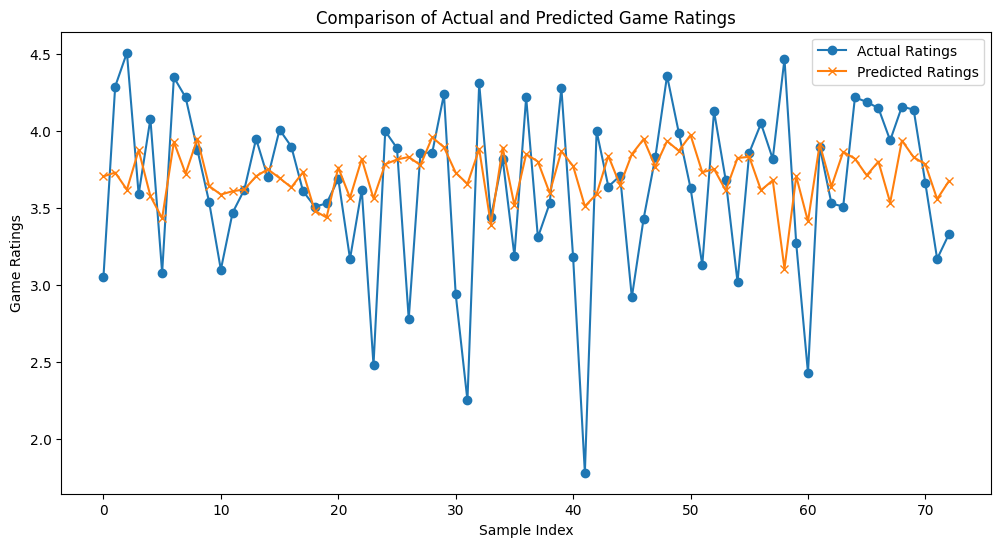

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, label="Actual Ratings", marker='o')
plt.plot(results_df['Predicted'].values, label="Predicted Ratings", marker='x')
plt.xlabel("Sample Index")
plt.ylabel("Game Ratings")
plt.title("Comparison of Actual and Predicted Game Ratings")
plt.legend()
plt.show()


In [10]:
'''# save CSV file
results_df.to_csv("model2_predictions.csv", index=False)'''

In [20]:
#Prediction of game rating based on model 1 output


model_1_output = pd.read_csv('/Users/hengjiyao/Desktop/spml sem1/EE6405 NLP/6GN-GameRatingPrediction/model_1_output_2.csv')

X_new = model_1_output.loc[:, '0.0-0.1':'0.9-1.0'].values  # features

# standardize
scaler = StandardScaler()
X_new = scaler.fit_transform(X_new)  

# tensor
X_new_tensor = torch.tensor(X_new, dtype=torch.float32)

# evaluation
model.eval()

# prediction
with torch.no_grad():
    predictions = model(X_new_tensor)

# save csv
model_1_output['predicted_score'] = predictions.numpy()
model_1_output.to_csv('model_1_output_with_prediction.csv', index=False)

print("model_1_output_with_prediction.csv")

model_1_output_with_prediction.csv
